In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from skimage import io
from torch.utils.data import Dataset,DataLoader
import os
import torch.nn.functional as F
from torch.utils.data import random_split
from sklearn.metrics import classification_report

In [2]:
data = r'A:\two class data\2class'
meta = r'A:\two class data\met2.csv'

In [3]:
class Custom(Dataset):
    def __init__(self, data_dir, transform):      
    
        # path to images
        path2data=os.path.join(data_dir)

        # get list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        path2csvLabels=os.path.join(meta)
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("ID", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = io.imread(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [4]:
data_transformer = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(224),transforms.RandomHorizontalFlip(p=0.5),transforms.RandomVerticalFlip(p=0.5),transforms.RandomRotation(degrees=(0, 180))])
dataset = Custom(data,data_transformer)

In [5]:
len_histo = len(dataset)
len_train = int(0.8*len_histo)                 #length of training data = 80% of total data
len_val = len_histo-len_train

TrainTest_ds,Val_ds=random_split(dataset,[len_train,len_val])      #spilt the data


print("validation dataset length:", len(Val_ds))




length = len(TrainTest_ds)
len_train = int(0.9*length)
len_test = length-len_train

Train_ds,Test_ds = random_split(TrainTest_ds,[len_train,len_test])

print('Train dataset length: ',len(Train_ds))
print('Test dataset length: ',len(Test_ds))

validation dataset length: 1447
Train dataset length:  5206
Test dataset length:  579


In [6]:
train_dl = DataLoader(Train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(Val_ds, batch_size=16, shuffle=True)  
test_dl = DataLoader(Test_ds,batch_size=16, shuffle=False)

In [7]:
for batch,(x,y) in enumerate(val_dl):
  print(x.shape)
  print(y.shape)
  break

torch.Size([16, 1, 224, 224])
torch.Size([16])


In [8]:
class CovNet(nn.Module):
    def __init__(self,num_classes):
        super(CovNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=5),
            nn.PReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,kernel_size=5),
            nn.PReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,kernel_size=4),
            nn.PReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,kernel_size=4),
            nn.PReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,512,kernel_size=4),
            nn.PReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.avg = nn.AdaptiveAvgPool2d((5,5))
        self.cls = nn.Sequential(
            nn.Linear(512*4*4,1000),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000,1000),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000,num_classes)
        )
        
    def forward(self,x):
        x = self.features(x)
        #x = self.avg(x)
        x = torch.flatten(x,1)
        x = self.cls(x)
        
        return F.log_softmax(x,dim=1)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
CNN = CovNet(2)
CNN.to(device)
optiM = optim.Adam(CNN.parameters(),lr=0.0001)

In [11]:

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


In [12]:
from torchsummary import summary
summary(CNN,(1,224,224))

C:\Users\dhart\anaconda3\envs\work\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 32, 220, 220]        832
|    └─PReLU: 2-2                        [-1, 32, 220, 220]        1
|    └─MaxPool2d: 2-3                    [-1, 32, 110, 110]        --
|    └─Conv2d: 2-4                       [-1, 64, 106, 106]        51,264
|    └─PReLU: 2-5                        [-1, 64, 106, 106]        1
|    └─MaxPool2d: 2-6                    [-1, 64, 53, 53]          --
|    └─Conv2d: 2-7                       [-1, 128, 50, 50]         131,200
|    └─PReLU: 2-8                        [-1, 128, 50, 50]         1
|    └─MaxPool2d: 2-9                    [-1, 128, 25, 25]         --
|    └─Conv2d: 2-10                      [-1, 256, 22, 22]         524,544
|    └─PReLU: 2-11                       [-1, 256, 22, 22]         1
|    └─MaxPool2d: 2-12                   [-1, 256, 11, 11]         --
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 32, 220, 220]        832
|    └─PReLU: 2-2                        [-1, 32, 220, 220]        1
|    └─MaxPool2d: 2-3                    [-1, 32, 110, 110]        --
|    └─Conv2d: 2-4                       [-1, 64, 106, 106]        51,264
|    └─PReLU: 2-5                        [-1, 64, 106, 106]        1
|    └─MaxPool2d: 2-6                    [-1, 64, 53, 53]          --
|    └─Conv2d: 2-7                       [-1, 128, 50, 50]         131,200
|    └─PReLU: 2-8                        [-1, 128, 50, 50]         1
|    └─MaxPool2d: 2-9                    [-1, 128, 25, 25]         --
|    └─Conv2d: 2-10                      [-1, 256, 22, 22]         524,544
|    └─PReLU: 2-11                       [-1, 256, 22, 22]         1
|    └─MaxPool2d: 2-12                   [-1, 256, 11, 11]         --
|   

In [13]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

In [14]:
def train(model,train_loader,validation_loader,loss_fn,optimizer,n_epochs,device):
    model = model.to(device)
    for epoch in range(n_epochs):
        training_loss = 0
        train_corr = 0
        totals = 0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input ,target = batch
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            loss = loss_fn(output,target)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()*target.size(0)
            totals += target.size(0)
            predicted = torch.argmax(output,1)
            train_corr += (predicted == target).sum().item()



        validation_loss = 0
        val_corr = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for batch in validation_loader:
                input ,target = batch
                input = input.to(device)
                target = target.to(device)
                output = model(input)
                loss = loss_fn(output,target)
                total += target.size(0)
                validation_loss += loss.item()*target.size(0)
                predicted = torch.argmax(output,1)
                val_corr += (predicted == target).sum().item()


        train_acc = train_corr/totals*100
        val_acc = val_corr/total*100
        training_loss = training_loss/totals
        validation_loss = validation_loss/total
        train_losses.append(training_loss)
        val_losses.append(validation_loss)
        train_accuracy.append(train_acc)
        val_accuracy.append(val_acc)


    
        print('Epoch : {}/{} ...Training Acc : {:.6f}     Training Loss : {:.6f}     Validation Acc : {:.6f}     Validation Loss : {:.6f}'.format(epoch+1,n_epochs,train_acc,training_loss,val_acc,validation_loss))





      

In [15]:
train(CNN,train_dl,val_dl,nn.NLLLoss(),optiM,100,device=device)

Epoch : 1/100 ...Training Acc : 55.436035     Training Loss : 0.680891     Validation Acc : 65.445750     Validation Loss : 0.644097
Epoch : 2/100 ...Training Acc : 70.169036     Training Loss : 0.573809     Validation Acc : 67.311679     Validation Loss : 0.591371
Epoch : 3/100 ...Training Acc : 77.180177     Training Loss : 0.482370     Validation Acc : 78.645473     Validation Loss : 0.441986
Epoch : 4/100 ...Training Acc : 79.427584     Training Loss : 0.444027     Validation Acc : 75.604699     Validation Loss : 0.490876
Epoch : 5/100 ...Training Acc : 80.503265     Training Loss : 0.428274     Validation Acc : 80.787837     Validation Loss : 0.411638
Epoch : 6/100 ...Training Acc : 81.444487     Training Loss : 0.402335     Validation Acc : 82.584658     Validation Loss : 0.388123
Epoch : 7/100 ...Training Acc : 83.077219     Training Loss : 0.374852     Validation Acc : 82.584658     Validation Loss : 0.372736
Epoch : 8/100 ...Training Acc : 83.960814     Training Loss : 0.36739

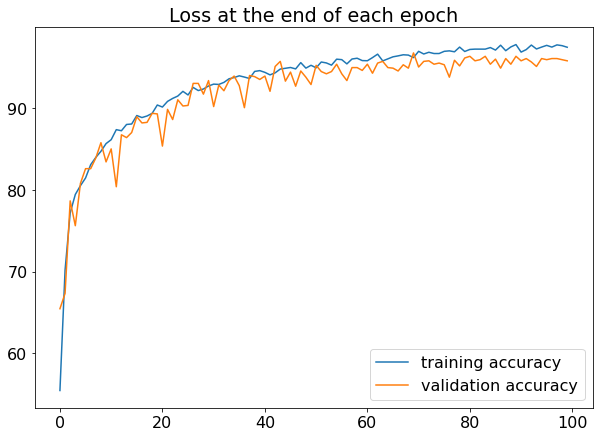

In [16]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 16})
plt.plot(train_accuracy, label='training accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

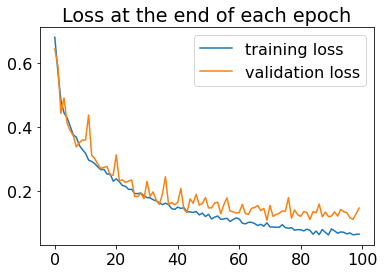

In [17]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [18]:
test_losses = []
test_accuracy = []

In [19]:
def test(model,test_loader,loss_fn,n_epochs,device=device):
    test_loss = 0
    test_corr = 0
    totals = 0
    y_pred = []
    y_true = []
    model.eval()
    for epoch in range(n_epochs):
        with torch.no_grad():
            for data in test_loader:
                input ,target = data
                input = input.to(device)
                target = target.to(device)
                output = model(input)
                loss = loss_fn(output,target)
                test_loss += loss.item()*target.size(0)
                totals += target.size(0)
                predicted = torch.argmax(output,1)
                test_corr = (predicted==target).sum().item()
                y_true.append(target)
                y_pred.append(predicted)

        test_loss = test_loss/totals
        test_acc = test_corr/totals*100
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        print('----------------------------------------------------------------------------')
        print('Y_true:{}'.format(y_true))
        print('----------------------------------------------------------------------------')
        print('Y_pred:{}'.format(y_pred))

    

In [20]:
test(CNN,test_dl,nn.NLLLoss(),1,device=device)

----------------------------------------------------------------------------
Y_true:[tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0'), tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0'), tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0'), tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0'), tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0'), tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0'), tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0'), tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0'), tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0'), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0'), tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0'), tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0'), tensor([1, 1, 0

In [2]:
y_true = [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,1, 1, 0]

In [5]:
count = 0
for i in range(len(y_true)):
    if y_true[i]==1:
        count = count+1

In [7]:
count/579

0.47668393782383417

In [23]:
y_pred = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,1, 1, 0]


In [28]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report,confusion_matrix
print('Accuracy : {}'.format(accuracy_score(y_true,y_pred)*100))
print('F1 Score : {}'.format(f1_score(y_true,y_pred)*100))
print('Sensitivity : {}'.format(recall_score(y_true,y_pred)*100))
print('Precision : {}'.format(precision_score(y_true,y_pred)*100))

Accuracy : 96.89119170984456
F1 Score : 96.7741935483871
Sensitivity : 97.82608695652173
Precision : 95.74468085106383


In [29]:
target_names = ['COVID','NORMAL']
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

       COVID       0.98      0.96      0.97       303
      NORMAL       0.96      0.98      0.97       276

    accuracy                           0.97       579
   macro avg       0.97      0.97      0.97       579
weighted avg       0.97      0.97      0.97       579



In [30]:
confusion_matrix(y_true, y_pred)

array([[291,  12],
       [  6, 270]], dtype=int64)

## Train time : 9:51 - 12:01 hrs
## Parameters : 12,001,513

In [32]:
train_accuracy 

[55.436035343834035,
 70.16903572800615,
 77.18017671917019,
 79.42758355743373,
 80.50326546292739,
 81.44448713023435,
 83.07721859393008,
 83.9608144448713,
 84.70995005762582,
 85.65117172493277,
 86.13138686131386,
 87.36073761044948,
 87.22627737226277,
 87.99462159047253,
 88.05224740683826,
 89.08951210142145,
 88.83980023050326,
 89.0318862850557,
 89.35843257779486,
 90.37648866692278,
 90.12677679600462,
 90.81828659239339,
 91.18325009604303,
 91.47137917787168,
 92.04763734152901,
 91.6058394160584,
 92.5278524779101,
 92.14368036880522,
 92.33576642335767,
 92.7007299270073,
 92.93123319247023,
 92.89281598155974,
 93.14252785247791,
 93.58432577794852,
 93.73799462159047,
 93.94928928159815,
 93.7956204379562,
 93.622742988859,
 94.48713023434499,
 94.58317326162121,
 94.37187860161352,
 94.06454091432963,
 94.31425278524779,
 94.77525931617365,
 94.87130234344987,
 94.9673453707261,
 94.7944679216289,
 95.56281213983866,
 94.8905109489051,
 95.2362658470995,
 94.9289281

In [34]:
val_accuracy

[65.44574982722875,
 67.3116793365584,
 78.64547339322738,
 75.6046993780235,
 80.78783690393918,
 82.58465791292329,
 82.58465791292329,
 83.8977194194886,
 85.76364892881824,
 83.4139599170698,
 85.00345542501728,
 80.37318590186592,
 86.73116793365584,
 86.38562543192812,
 87.00760193503801,
 88.94263994471319,
 88.18244644091223,
 88.25155494125777,
 89.35729094678645,
 89.28818244644091,
 85.34899792674499,
 89.84105044920526,
 88.59709744298549,
 91.01589495507947,
 90.2557014512785,
 90.32480995162405,
 93.0200414651002,
 93.0200414651002,
 91.7069799585349,
 93.36558396682793,
 90.18659295093296,
 92.81271596406357,
 92.12163096060816,
 93.36558396682793,
 93.91845196959227,
 92.74360746371804,
 90.04837595024188,
 93.9875604699378,
 93.84934346924672,
 93.503800967519,
 93.91845196959227,
 92.05252246026261,
 95.09329647546649,
 95.71527297857637,
 93.29647546648238,
 94.40221147201106,
 92.6744989633725,
 94.54042847270215,
 93.78023496890118,
 92.88182446440912,
 95.23151347

In [39]:
torch.save(CNN.state_dict(), r'A:\saved models\custom1.pth')

In [1]:
train_accuracy = [55.436035343834035,
 70.16903572800615,
 77.18017671917019,
 79.42758355743373,
 80.50326546292739,
 81.44448713023435,
 83.07721859393008,
 83.9608144448713,
 84.70995005762582,
 85.65117172493277,
 86.13138686131386,
 87.36073761044948,
 87.22627737226277,
 87.99462159047253,
 88.05224740683826,
 89.08951210142145,
 88.83980023050326,
 89.0318862850557,
 89.35843257779486,
 90.37648866692278,
 90.12677679600462,
 90.81828659239339,
 91.18325009604303,
 91.47137917787168,
 92.04763734152901,
 91.6058394160584,
 92.5278524779101,
 92.14368036880522,
 92.33576642335767,
 92.7007299270073,
 92.93123319247023,
 92.89281598155974,
 93.14252785247791,
 93.58432577794852,
 93.73799462159047,
 93.94928928159815,
 93.7956204379562,
 93.622742988859,
 94.48713023434499,
 94.58317326162121,
 94.37187860161352,
 94.06454091432963,
 94.31425278524779,
 94.77525931617365,
 94.87130234344987,
 94.9673453707261,
 94.7944679216289,
 95.56281213983866,
 94.8905109489051,
 95.2362658470995,
 94.9289281598156,
 95.63964656165962,
 95.52439492892816,
 95.25547445255475,
 95.98540145985402,
 95.92777564348827,
 95.4091432961967,
 96.00461006530927,
 96.10065309258547,
 95.81252401075682,
 95.79331540530157,
 96.17748751440645,
 96.60007683442183,
 95.77410679984632,
 96.0238186707645,
 96.27353054168267,
 96.38878217441413,
 96.52324241260084,
 96.48482520169036,
 96.17748751440645,
 96.94583173261621,
 96.61928543987706,
 96.83058009988474,
 96.67691125624279,
 96.67691125624279,
 96.94583173261621,
 97.00345754898194,
 96.88820591625048,
 97.4644640799078,
 96.92662312716097,
 97.17633499807914,
 97.21475220898964,
 97.21475220898964,
 97.21475220898964,
 97.40683826354206,
 97.09950057625817,
 97.69496734537073,
 97.02266615443719,
 97.48367268536305,
 97.7718017671917,
 96.84978870533999,
 97.1571263926239,
 97.71417595082596,
 97.23396081444487,
 97.4644640799078,
 97.67575873991548,
 97.4644640799078,
 97.73338455628121,
 97.637341529005,
 97.44525547445255]

In [2]:
val_accuracy = [65.44574982722875,
 67.3116793365584,
 78.64547339322738,
 75.6046993780235,
 80.78783690393918,
 82.58465791292329,
 82.58465791292329,
 83.8977194194886,
 85.76364892881824,
 83.4139599170698,
 85.00345542501728,
 80.37318590186592,
 86.73116793365584,
 86.38562543192812,
 87.00760193503801,
 88.94263994471319,
 88.18244644091223,
 88.25155494125777,
 89.35729094678645,
 89.28818244644091,
 85.34899792674499,
 89.84105044920526,
 88.59709744298549,
 91.01589495507947,
 90.2557014512785,
 90.32480995162405,
 93.0200414651002,
 93.0200414651002,
 91.7069799585349,
 93.36558396682793,
 90.18659295093296,
 92.81271596406357,
 92.12163096060816,
 93.36558396682793,
 93.91845196959227,
 92.74360746371804,
 90.04837595024188,
 93.9875604699378,
 93.84934346924672,
 93.503800967519,
 93.91845196959227,
 92.05252246026261,
 95.09329647546649,
 95.71527297857637,
 93.29647546648238,
 94.40221147201106,
 92.6744989633725,
 94.54042847270215,
 93.78023496890118,
 92.88182446440912,
 95.23151347615757,
 94.47131997235661,
 94.19488597097443,
 94.47131997235661,
 95.36973047684866,
 94.19488597097443,
 93.36558396682793,
 94.95507947477539,
 94.95507947477539,
 94.60953697304768,
 95.36973047684866,
 94.26399447131996,
 95.50794747753973,
 95.71527297857637,
 94.95507947477539,
 94.88597097442985,
 94.54042847270215,
 95.30062197650311,
 94.88597097442985,
 96.7519004837595,
 95.02418797512094,
 95.71527297857637,
 95.78438147892192,
 95.36973047684866,
 95.50794747753973,
 95.30062197650311,
 93.78023496890118,
 95.85348997926745,
 95.16240497581202,
 96.12992398064962,
 96.33724948168624,
 95.78438147892192,
 95.922598479613,
 96.33724948168624,
 95.36973047684866,
 95.99170697995854,
 94.88597097442985,
 96.06081548030407,
 95.36973047684866,
 96.33724948168624,
 95.78438147892192,
 96.06081548030407,
 95.64616447823082,
 95.09329647546649,
 96.06081548030407,
 95.922598479613,
 96.06081548030407,
 96.06081548030407,
 95.922598479613,
 95.78438147892192]

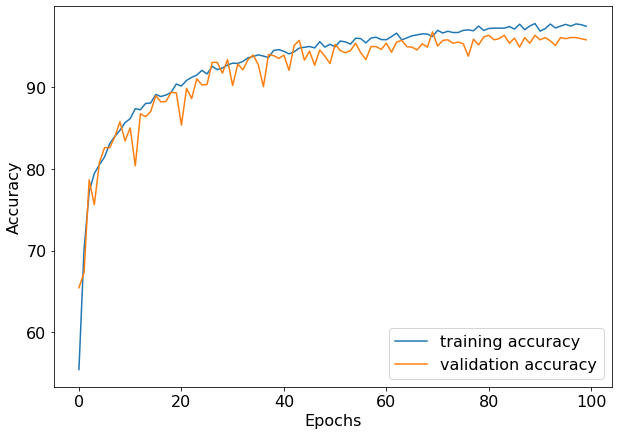

In [5]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 16})
plt.plot(train_accuracy, label='training accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

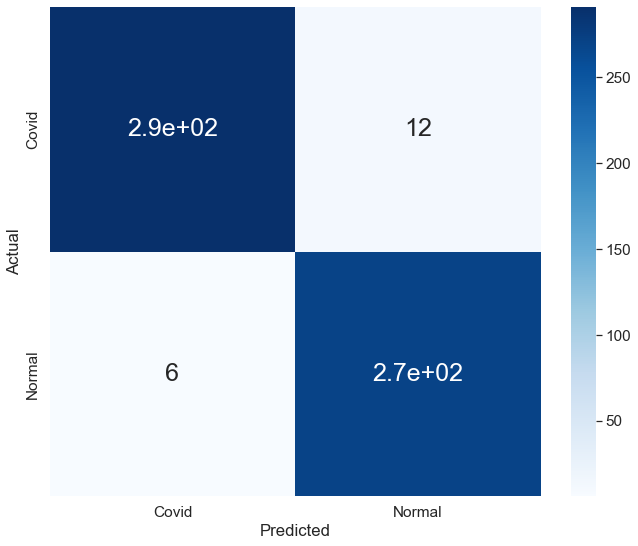

In [6]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

y_true = [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,1, 1, 0]
y_pred = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,1, 1, 0]

data = confusion_matrix(y_true, y_pred)
cls = ['Covid','Normal']
df_cm = pd.DataFrame(data, columns=np.unique(cls), index = np.unique(cls))
#df_cm = (df_cm-df_cm.mean())/df_cm.std()
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (11,9))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25})